# CNN Regression Model

In [42]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load

## Sample

<AxesSubplot:title={'center':'Velocity'}>

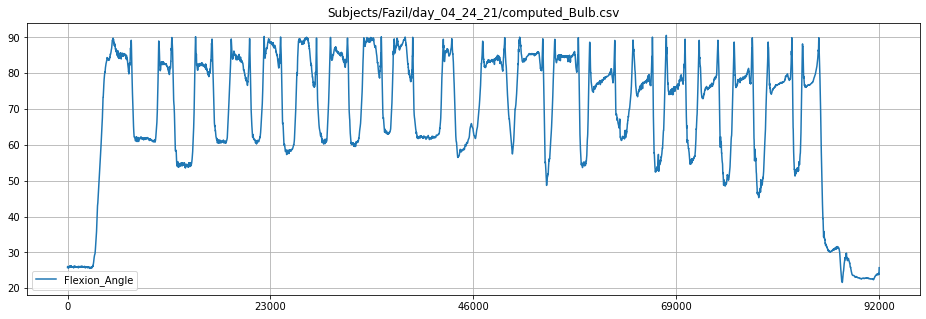

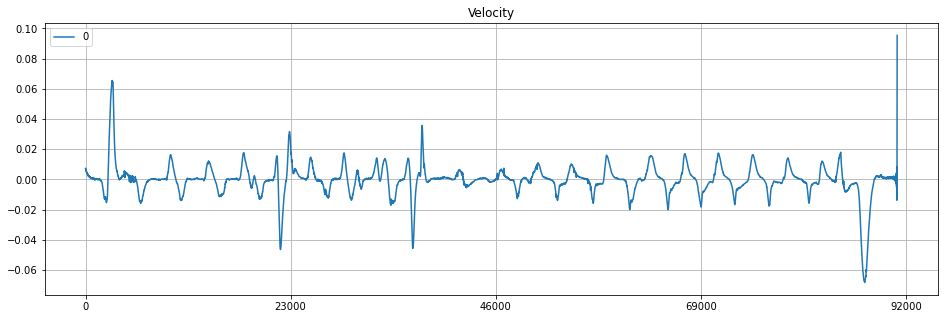

In [43]:
file = 'Subjects/Fazil/day_04_24_21/computed_Bulb.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Flexion_Angle'] # 'Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle'
df = pd.read_csv(file,index_col=0)
df[angle_lables].plot(figsize=(16,5),title=file,grid=True,xticks=np.linspace(0,len(df),5))

arr = np.diff([0]+list(df['Pronation_Angle']))
# arr = arr/df.index
b,a = signal.butter(1, 1,fs=2000)
arr = signal.lfilter(b, a,arr)
pd.DataFrame(arr[1000:]).plot(figsize=(16,5),title='Velocity',grid=True,xticks=np.linspace(0,len(df),5))

## Prep Data

In [44]:
window = 250

In [45]:
files = []
subjects = ['Fazil/day_04_24_21','Nikhil/day_05_13_21'] #'Fazil/day_04_14_21'
for subj in subjects:
    path = 'Subjects/'+subj
    # trial_names = ['Bulb','Hammer'] # 'Bulb','Hammer' ,'Cup','Screw'
    trial_names = ['Bulb','Hammer' ,'Cup','Screw'] #,
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                files.append(path+'/computed_'+exp+'.csv')
            else:
                files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Fazil/day_04_24_21/computed_Bulb.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Cup.csv',
 'Subjec

In [46]:
files = files[1:]

['Subjects/Fazil/day_04_24_21/computed_Bulb01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Cup.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Cup01.csv',
 'Subj

In [47]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0))

In [48]:
files_df = filter_df(files_df)

In [49]:
X, y = multiple_prep_data_velocity(files_df,250,interval=10,Normalize=False,rms=False,angle_label ='Pronation_Angle')
X.shape

(142625, 250, 8)

## Time Window Normalize

In [50]:
X_mean = np.zeros(X[0].shape)
for x in X:
    X_mean = X_mean + x
X_mean = X_mean/X.shape[0]
X_std = np.sqrt(variance(X))
np.save('mean_std',np.array([X_mean,X_std]))

In [51]:
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

## Test Train Split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(114100, 250, 8)
(28525, 250, 8)
(114100, 1)
(28525, 1)


# Neural Network Regression

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
n_outputs = 1

In [56]:
n_outputs = 1
in_shape = (X.shape[1],X.shape[2])

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=in_shape))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=26, kernel_size=3, activation='relu'))

# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
# model.add(Dense(64,activation='relu'))
model.add(Dense(n_outputs))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 248, 64)           1600      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 246, 32)           6176      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 244, 26)           2522      
_________________________________________________________________
dropout_3 (Dropout)          (None, 244, 26)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6344)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6345      
Total params: 16,643
Trainable params: 16,643
Non-trainable params: 0
__________________________________________________

In [59]:
cnn_history=model.fit(X_train,y_train,epochs = 200,batch_size = 10000,validation_data = (X_test,y_test) )

Epoch 1/200
12/12 [==============================] - 4s 253ms/step - loss: 0.9207 - val_loss: 0.9277
Epoch 2/200
12/12 [==============================] - 3s 253ms/step - loss: 0.9148 - val_loss: 0.9182
Epoch 3/200
12/12 [==============================] - 3s 252ms/step - loss: 0.9047 - val_loss: 0.9082
Epoch 4/200
12/12 [==============================] - 3s 261ms/step - loss: 0.8959 - val_loss: 0.8946
Epoch 5/200
12/12 [==============================] - 3s 260ms/step - loss: 0.8836 - val_loss: 0.8805
Epoch 6/200
12/12 [==============================] - 3s 256ms/step - loss: 0.8703 - val_loss: 0.8623
Epoch 7/200
12/12 [==============================] - 3s 256ms/step - loss: 0.8570 - val_loss: 0.8477
Epoch 8/200
12/12 [==============================] - 3s 256ms/step - loss: 0.8448 - val_loss: 0.8378
Epoch 9/200
12/12 [==============================] - 3s 257ms/step - loss: 0.8373 - val_loss: 0.8281
Epoch 10/200
12/12 [==============================] - 3s 257ms/step - loss: 0.8219 - val_lo

12/12 [==============================] - 3s 281ms/step - loss: 0.5067 - val_loss: 0.4842
Epoch 82/200
12/12 [==============================] - 4s 301ms/step - loss: 0.5196 - val_loss: 0.5072
Epoch 83/200
12/12 [==============================] - 4s 309ms/step - loss: 0.5180 - val_loss: 0.5030
Epoch 84/200
12/12 [==============================] - 4s 307ms/step - loss: 0.5130 - val_loss: 0.4955
Epoch 85/200
12/12 [==============================] - 4s 308ms/step - loss: 0.5074 - val_loss: 0.4817
Epoch 86/200
12/12 [==============================] - 4s 308ms/step - loss: 0.4965 - val_loss: 0.4785
Epoch 87/200
12/12 [==============================] - 4s 308ms/step - loss: 0.4937 - val_loss: 0.4860
Epoch 88/200
12/12 [==============================] - 3s 288ms/step - loss: 0.4978 - val_loss: 0.4786
Epoch 89/200
12/12 [==============================] - 3s 292ms/step - loss: 0.4903 - val_loss: 0.4760
Epoch 90/200
12/12 [==============================] - 4s 302ms/step - loss: 0.4897 - val_loss: 

Epoch 161/200
12/12 [==============================] - 4s 309ms/step - loss: 0.3910 - val_loss: 0.3742
Epoch 162/200
12/12 [==============================] - 4s 307ms/step - loss: 0.3883 - val_loss: 0.3888
Epoch 163/200
12/12 [==============================] - 4s 307ms/step - loss: 0.3891 - val_loss: 0.3708
Epoch 164/200
12/12 [==============================] - 4s 309ms/step - loss: 0.3833 - val_loss: 0.3823
Epoch 165/200
12/12 [==============================] - 4s 308ms/step - loss: 0.3870 - val_loss: 0.3705
Epoch 166/200
12/12 [==============================] - 4s 309ms/step - loss: 0.3807 - val_loss: 0.3680
Epoch 167/200
12/12 [==============================] - 4s 307ms/step - loss: 0.3807 - val_loss: 0.3649
Epoch 168/200
12/12 [==============================] - 4s 308ms/step - loss: 0.3787 - val_loss: 0.3692
Epoch 169/200
12/12 [==============================] - 4s 308ms/step - loss: 0.3774 - val_loss: 0.3654
Epoch 170/200
12/12 [==============================] - 4s 308ms/step - lo

In [60]:
model.save('models/prosup_velocity_model_{}.hdf5'.format(window))

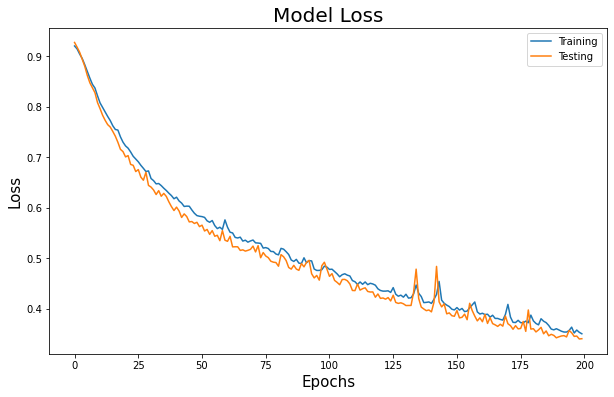

In [61]:
plot_model(cnn_history)

In [25]:
import matplotlib.pyplot as plt
def plot_model(history):
#     plt.figure(figsize=(10,6))
#     plt.plot(history.history['root_mean_squared_error'][1:])
#     plt.plot(history.history['val_root_mean_squared_error'][1:])
#     plt.title('Model RMSE',size=20)
#     plt.ylabel('RMSE Loss',size=15)
#     plt.xlabel('Epochs', size=15)
#     plt.legend(['Training', 'Testing'], loc='best')
#     plt.show()
    
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss',size=20)
    plt.ylabel('Loss',size=15)
    plt.xlabel('Epochs',size=15)
    plt.legend(['Training', 'Testing'], loc='best')
    plt.show()

## Model Testing

In [62]:
file = 'Subjects/Fazil/day_04_24_21/computed_Bulb.csv'
df = pd.read_csv(file,index_col=0)

In [63]:
X, y = prep_data_velocity(df,window,interval=10,Normalize=False,rms=False,angle_label ='Pronation_Angle')

In [64]:
X_mean = np.load('mean_std.npy')[0]
X_std = np.load('mean_std.npy')[1]
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

In [65]:
pred = model.predict(X)

In [66]:
from sklearn.metrics import mean_squared_error
print('RMSE Score=',mean_squared_error(y,pred,squared=False))

RMSE Score= 1.3572615875588971


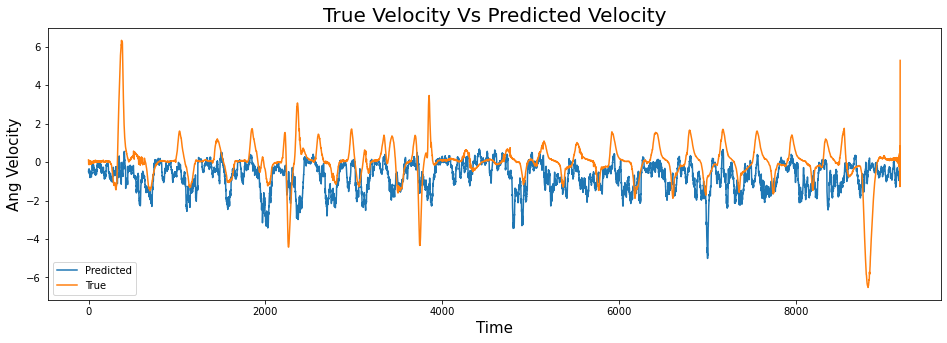

In [67]:
plt.figure(figsize=(16,5))
plt.plot(pred)
plt.plot(y)
plt.title('True Velocity Vs Predicted Velocity',size=20)
plt.ylabel('Ang Velocity',size=15)
plt.xlabel('Time', size=15)
plt.legend(['Predicted', 'True'], loc='best')
plt.show()